# Detecting SQL injections using BERT 

**Install nedded libraries**

In [1]:
!pip install ktrain 
!pip install chardet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 61.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 64.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.4/265.4 KB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 106.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 KB 46.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━

**Importing the libraries**

In [2]:
import numpy as np
import ktrain
from ktrain import text
import pandas as pd
import chardet
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
import seaborn as sns
import pickle

**Reading and displaying the dataset**

In [3]:
# Detect the encoding of the CSV file
with open('SQLiV3.csv', 'rb') as f:
    result = chardet.detect(f.read())

# Read the CSV file into a pandas dataframe, using the detected encoding
# df = pd.read_csv('sqliv2.csv', sep=',',  encoding=result['encoding']).sample(n=250)
df = pd.read_csv('SQLiV3.csv', sep=',',  encoding=result['encoding'])

# Display the first rows of the dataframe
print(df.head(10))

                                            Sentence  Label
0                  " or pg_sleep  (  __TIME__  )  --      1
1   AND 1  =  utl_inaddr.get_host_address   (    ...      1
2   select * from users where id  =  '1' or @ @1 ...      1
3   select * from users where id  =  1 or 1#"  ( ...      1
4   select name from syscolumns where id   =     ...      1
5  select * from users where id  =  1 +$+ or 1  =...      1
6  1;  (  load_file  (  char  (  47,101,116,99,47...      1
7   select * from users where id  =  '1' or ||/1 ...      1
8   select * from users where id  =  '1' or \.<\ ...      1
9                                    ? or 1  =  1 --      1


In [4]:
df.shape

(30608, 2)

In [5]:
print("----------------------------------------------------")
df.info()
print("----------------------------------------------------")

----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30608 entries, 0 to 30607
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  30608 non-null  object
 1   Label     30608 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 478.4+ KB
----------------------------------------------------


In [6]:
df['Label'].describe()


count    30608.000000
mean         0.370491
std          0.482944
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Label, dtype: float64

**Process NaN values**

In [7]:
df['Label'].isna().sum() # Count NaN label values.


0

**the target label**

In [8]:
# Get unique values existing in the label column.

unique_label = pd.unique(df['Label'])

print(unique_label)

[1 0]


In [9]:
df[df['Label'] == 1].count() # Count how much label are 1.


Sentence    11340
Label       11340
dtype: int64

In [10]:
df[df['Label'] == 0].count() # Count how much label are 0.


Sentence    19268
Label       19268
dtype: int64

**Distribution of the label**

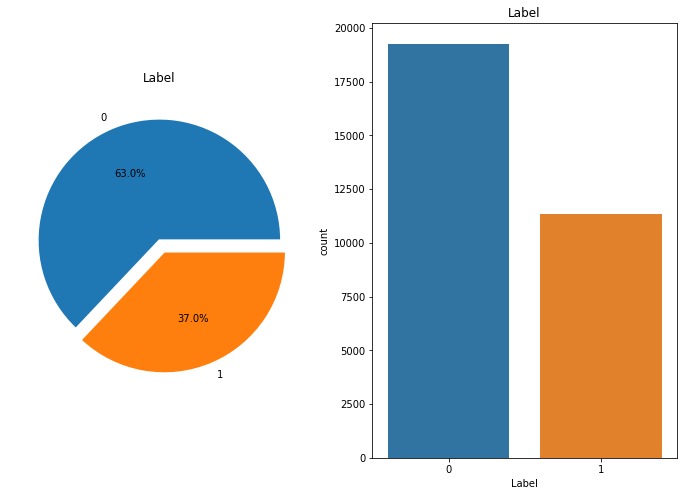

In [11]:
import matplotlib.colors as mcolors
f, ax = plt.subplots(1, 2, figsize=(12, 8))
colors = list(mcolors.TABLEAU_COLORS.values())
df['Label'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], wedgeprops={'edgecolor': 'white', 'linewidth': 2, 'antialiased': True}, colors=colors)

ax[0].set_title('Label')
ax[0].set_ylabel('')
sns.countplot('Label', data=df, ax=ax[1], palette=colors)
ax[1].set_title('Label')
plt.show()


**Creating the training and test sets**

In [42]:
sentences = df['Sentence'].tolist()
labels = df['Label'].tolist()

sentences_train, sentences_test, labels_train, labels_test = train_test_split(sentences, labels, test_size=0.2, random_state=1500)

(x_train, y_train), (x_test, y_test), preproc = text.texts_from_array(sentences_train, labels_train, 
                                                                       preprocess_mode='bert',
                                                                       maxlen=100,
                                                                      class_names=list(set(labels_train))
                                                                      )

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


# Building the BERT model

In [43]:
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 100


/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


# Training the BERT model

In [44]:
learner = ktrain.get_learner(model=model,
                             train_data=(x_train, y_train),
                             val_data=(x_test, y_test),
                             batch_size=6)

In [45]:
learner.fit_onecycle(lr=2e-5, epochs=4)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/4
3673/3673 [==============================] - 177s 43ms/step - loss: 0.0221 - accuracy: 0.9926 - val_loss: 0.0054 - val_accuracy: 0.9971
Epoch 2/4
3673/3673 [==============================] - 152s 41ms/step - loss: 0.0075 - accuracy: 0.9980 - val_loss: 0.0197 - val_accuracy: 0.9971
Epoch 3/4
3673/3673 [==============================] - 153s 42ms/step - loss: 0.0061 - accuracy: 0.9985 - val_loss: 0.0113 - val_accuracy: 0.9980
Epoch 4/4
3673/3673 [==============================] - 152s 42ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0102 - val_accuracy: 0.9984


In [46]:
learner.validate(class_names=preproc.get_classes())


77/77 [==============================] - 6s 26ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1519
           1       1.00      1.00      1.00       930

    accuracy                           1.00      2449
   macro avg       1.00      1.00      1.00      2449
weighted avg       1.00      1.00      1.00      2449



array([[1519,    0],
       [   4,  926]])

**Inspecting Misclassifications**

In [47]:
learner.view_top_losses(n=30, preproc=preproc)

77/77 [==============================] - 2s 26ms/step
----------
id:1308 | loss:8.78 | true:1 | pred:0)

[CLS] # name ? [SEP]
----------
id:1728 | loss:8.78 | true:1 | pred:0)

[CLS] # name ? [SEP]
----------
id:523 | loss:5.26 | true:1 | pred:0)

[CLS] handler [SEP]
----------
id:1971 | loss:1.68 | true:1 | pred:0)

[CLS] sql ##vu ##ln [SEP]


In [49]:
predictor = ktrain.get_predictor(learner.model, preproc)

# make predictions 
samples = [
     "1'; DROP TABLE users;--;",
     "INSERT INTO users (username, password) VALUES ('testuser', 'testpassword'); DROP TABLE users;",
     "SELECT COUNT(*) FROM users WHERE username = 'admin' OR 1=1;",
     "UPDATE users SET password = 'newpassword' WHERE username = 'admin';" ]
prediction = predictor.predict(samples)
print(prediction)

1/1 [==============================] - 0s 37ms/step
[1, 0, 1, 0]


# Save Trained Model

In [51]:
with open('final_model.pkl', 'wb') as f:
    pickle.dump(predictor, f)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......add
.........vars
......add_1
.........vars
......add_10
.........vars
......add_11
.........vars
......add_12
.........vars
......add_13
.........vars
......add_14
.........vars
......add_15
.........vars
......add_16
.........vars
......add_17
.........vars
......add_18
.........vars
......add_19
.........vars
......add_2
.........vars
......add_20
.........vars
......add_21
.........vars
......add_22
.........vars
......add_23
.........vars
......add_24
.........vars
......add_3
.........vars
......add_4
.........vars
......add_5
.........vars
......add_6
.........vars
......add_7
.........vars
......add_8
.........vars
......add_9
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_10
.........vars
......dropout_11
.........vars
......dropout_12
.........vars


# Load Trained Model

In [ ]:
# # Load the saved model from file
# with open('model.pkl', 'rb') as f:
#     model = pickle.load(f)

# # Use the loaded model
# model.predict(...)